## Henon Heiles System

In [1]:
import os
import sys
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
sys.path.append("..")
from prepare_data import PrepareData, HenonHeilesData, SimulateHenonHeiles  # noqa E402
from GFNN import GFNN  # noqa E402

### Prepare Chaotic Data

In [2]:
CURRENT_DIR = str(pathlib.Path(".").parent.absolute())
h = 0.5
q0 = np.array([np.sqrt(1/6), 0])
p0 = np.array([np.sqrt(1/6), 0])
prefix = "regular_"
train_file_path, test_file_path = PrepareData(CURRENT_DIR + "/data",
                                              q0, p0,
                                              h=h,
                                              n_train=100000,
                                              n_test=100,
                                              seq_len=2,
                                              n_processors=10,
                                              prefix = prefix)

parameters = {
    "dim": 2,
    "step_size": h,
    "train_file_path": train_file_path,
    "test_file_path": test_file_path,
    "batch_size": 200,
    "n_neurons": [4, 200, 100, 50, 20, 1],
    "lr": 1e-2,
}

STORAGE_DIR = CURRENT_DIR + "/" + prefix +"h=" + str(h) + "/"
if not os.path.exists(STORAGE_DIR):
    os.mkdir(STORAGE_DIR)

 # Generating training data:
Start:  <SpawnProcess name='SpawnPoolWorker-1' parent=93984 started daemon>
Progress on thread 1
Start:  <SpawnProcess name='SpawnPoolWorker-2' parent=93984 started daemon>
Start:  <SpawnProcess name='SpawnPoolWorker-3' parent=93984 started daemon>
Start:  <SpawnProcess name='SpawnPoolWorker-4' parent=93984 started daemon>


  0%|          | 3/10000 [00:00<08:13, 20.24it/s]

Start:  <SpawnProcess name='SpawnPoolWorker-5' parent=93984 started daemon>
Start:  <SpawnProcess name='SpawnPoolWorker-6' parent=93984 started daemon>


  0%|          | 9/10000 [00:00<08:21, 19.94it/s]

Start:  <SpawnProcess name='SpawnPoolWorker-7' parent=93984 started daemon>
Start:  <SpawnProcess name='SpawnPoolWorker-8' parent=93984 started daemon>
Start:  <SpawnProcess name='SpawnPoolWorker-9' parent=93984 started daemon>


  0%|          | 14/10000 [00:00<08:23, 19.84it/s]

Start:  <SpawnProcess name='SpawnPoolWorker-10' parent=93984 started daemon>


 99%|█████████▉| 9880/10000 [07:28<00:04, 25.26it/s]

Finish:  <SpawnProcess name='SpawnPoolWorker-2' parent=93984 started daemon>


 99%|█████████▉| 9943/10000 [07:30<00:02, 26.78it/s]

Finish:  <SpawnProcess name='SpawnPoolWorker-7' parent=93984 started daemon>
Finish:  <SpawnProcess name='SpawnPoolWorker-6' parent=93984 started daemon>


100%|█████████▉| 9958/10000 [07:31<00:01, 31.20it/s]

Finish:  <SpawnProcess name='SpawnPoolWorker-5' parent=93984 started daemon>


100%|█████████▉| 9982/10000 [07:32<00:00, 33.68it/s]

Finish:  <SpawnProcess name='SpawnPoolWorker-10' parent=93984 started daemon>
Finish:  <SpawnProcess name='SpawnPoolWorker-3' parent=93984 started daemon>


100%|██████████| 10000/10000 [07:32<00:00, 22.09it/s]


Finish:  <SpawnProcess name='SpawnPoolWorker-1' parent=93984 started daemon>
Finish:  <SpawnProcess name='SpawnPoolWorker-9' parent=93984 started daemon>
Finish:  <SpawnProcess name='SpawnPoolWorker-4' parent=93984 started daemon>
Finish:  <SpawnProcess name='SpawnPoolWorker-8' parent=93984 started daemon>
 # Generating testing data:
Start:  <SpawnProcess name='SpawnPoolWorker-11' parent=93984 started daemon>
Start:  <SpawnProcess name='SpawnPoolWorker-12' parent=93984 started daemon>
Start:  <SpawnProcess name='SpawnPoolWorker-13' parent=93984 started daemon>
Start:  <SpawnProcess name='SpawnPoolWorker-14' parent=93984 started daemon>
Start:  <SpawnProcess name='SpawnPoolWorker-15' parent=93984 started daemon>
Start:  <SpawnProcess name='SpawnPoolWorker-16' parent=93984 started daemon>
Start:  <SpawnProcess name='SpawnPoolWorker-17' parent=93984 started daemon>
Start:  <SpawnProcess name='SpawnPoolWorker-18' parent=93984 started daemon>
Finish:  <SpawnProcess name='SpawnPoolWorker-11'

### Initialize (load) the model

In [4]:
nn = GFNN(parameters)
# If saved checkpoint of GFNN exists, load GFNN from the checkpoint.
# Uncomment the following two lines if a loaded GFNN is deseired.
# if os.path.exists(STORAGE_DIR + "/checkpoint.pt"):
#     nn.Load(STORAGE_DIR)

### Train

In [5]:
# Train.
epochs = 20
nn.Train(epochs)

# Serialize the trained model.
nn.Save(STORAGE_DIR)

Epoch 20: training loss=3.71e-07, testing loss=3.47e-07: 100%|██████████| 20/20 [00:43<00:00,  2.17s/it]


Text(0, 0.5, 'Training loss')

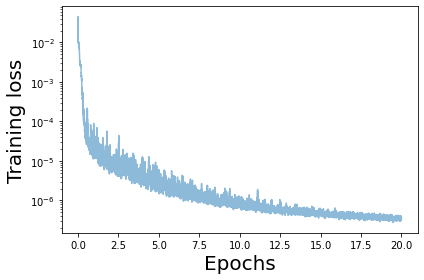

In [6]:
fig, ax = plt.subplots(tight_layout=True)
ax.semilogy((np.arange(len(nn.loss_array))+1)/(nn.n_train/nn.args["batch_size"]), nn.loss_array, alpha=0.5)
ax.set_xlabel("Epochs", fontsize=20)
ax.set_ylabel("Training loss", fontsize=20)

### Predict

In [7]:
def EvolveFlow(nn, q, p, n):
    """
    Evolve the flow by the trained GFNN.
    Args:
        q,p the initial condition
        n the steps to evolve
        nn the neural network
    """
    h = nn.args["step_size"]
    qspan = [q]
    pspan = [p]
    t = 0
    tspan = [t]
    for i in range(n):
        # one step evolution
        q, p = nn.Predict(q, p)
        t = t + h
        qspan.append(q)
        pspan.append(p)
        tspan.append(t)
    return np.array(tspan), np.array(qspan), np.array(pspan)

#### Evolve the flow

In [16]:
# Initial condition for prediction
q = np.array([np.sqrt(1/6)+0.001, 0.001])
p = np.array([np.sqrt(1/6)-0.001, 0.001])

steps = 10000

h_nn = nn.args["step_size"]
dim = nn.args["dim"]

h_sim = 0.01
ret_sim = SimulateHenonHeiles(np.array(q), np.array(p),
                          h_sim, int(steps * h_nn / h_sim))
qspan_sim = ret_sim[:, 0:dim]
pspan_sim = ret_sim[:, dim:2 * dim]
tspan_sim = h_sim * np.arange(0, qspan_sim.shape[0])
tspan_nn, qspan_nn, pspan_nn = EvolveFlow(nn, q, p, steps)

#### Plot

In [17]:
def GetPoincareSection(q, p):
    """
    Get the Poincare section around x=0: (y, py)

    Args:
        q: n*2 np array
        p: n*2 np array
    """
    sec = []
    for i in range(q.shape[0]-1):
        if (q[i, 0]*q[i+1, 0] < 0):
            sec.append([q[i, 1], p[i, 1]])
    return np.array(sec)

sec_sim = GetPoincareSection(qspan_sim, pspan_sim)
sec_nn = GetPoincareSection(qspan_nn, pspan_nn)

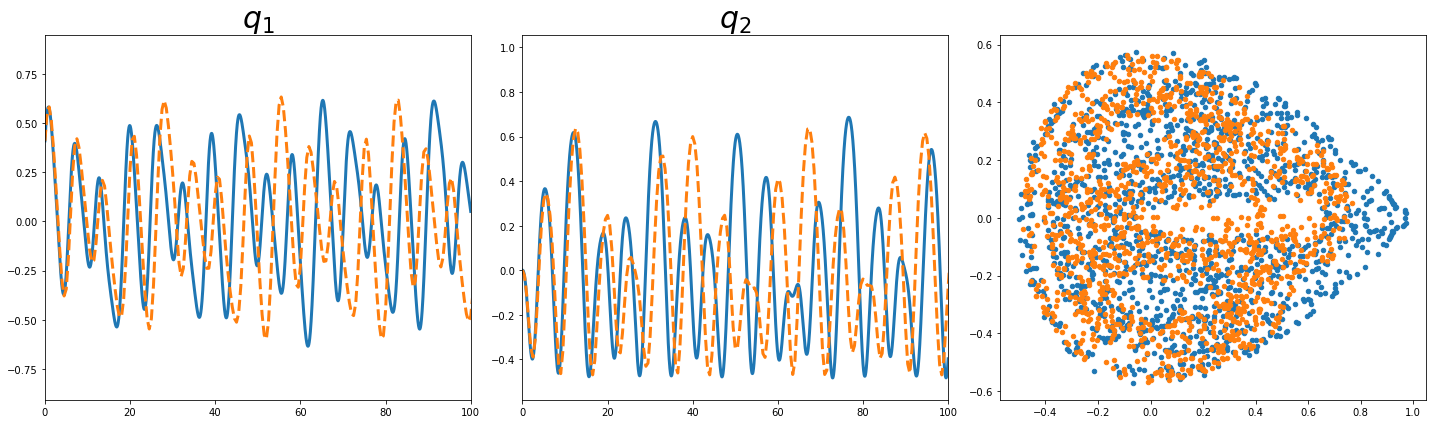

In [22]:
fig = plt.figure(tight_layout=True, figsize=(20, 6))
gs = gridspec.GridSpec(1, 3)

names = ["$q_1$", "$q_2$"]
for i in range(2):
    ax = fig.add_subplot(gs[0, i])
    ax.plot(tspan_sim, qspan_sim[:, i], linewidth=3, label="True")
    ax.plot(tspan_nn, qspan_nn[:, i], "--", linewidth=3, label="GFNN")
    ax.set_title(names[i], fontsize=30)
    ax.set_xlim([0, 100])
    
ax = fig.add_subplot(gs[0, 2])
ax.scatter(sec_sim[:, 0], sec_sim[:, 1], s=20, label="True")
ax.scatter(sec_nn[:, 0], sec_nn[:, 1], s=20, label="LSTM")